### Introduction

Build a model that can classify a text document as one of many possible classes

- Practice cleaning and exploring a text dataset with NLTK and base Python
- Practice using scikit-learn vectorizers for text preprocessing
- Tune a modeling process through exploration and model evaluation
- Observe some techniques for feature engineering
- Interpret the result of a final ML model that classifies text data

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [6]:
categories = [
    'comp.windows.x',
    'rec.sport.hockey',
    'misc.forsale',
    'sci.crypt',
    'talk.politics.misc'
]

newsgroups_train = fetch_20newsgroups(
    subset="train",
    remove=('headers', 'footers', 'quotes'),
    categories=categories
)

newsgroups_test = fetch_20newsgroups(
    subset="test",
    remove=('headers', 'footers', 'quotes'),
    categories=categories
)

In [7]:
type(newsgroups_train)


sklearn.utils.Bunch

In [9]:
import pandas as pd
pd.set_option('max_colwidth', 400)
pd.set_option('use_mathjax', False)

# Extract values from Bunch objects
X_train = pd.DataFrame(newsgroups_train.data, columns=["text"])
X_test = pd.DataFrame(newsgroups_test.data, columns=["text"])
y_train = pd.Series(newsgroups_train.target, name="category")
y_test = pd.Series(newsgroups_test.target, name="category")

Double-checking that the variables have the correct shape below:

In [10]:
# X_train and X_test both have 1 column (text)
assert X_train.shape[1] == X_test.shape[1] and X_train.shape[1] == 1

# y_train and y_test are 1-dimensional (target value only)
assert len(y_train.shape) == len(y_test.shape) and len(y_train.shape) == 1

# X_train and y_train have the same number of rows
assert X_train.shape[0] == y_train.shape[0] and X_train.shape[0] == 2838

# X_test and y_test have the same number of rows
assert X_test.shape[0] == y_test.shape[0] and X_test.shape[0] == 1890

### Distribution of Target


In [11]:
train_target_counts = pd.DataFrame(y_train.value_counts())
train_target_counts["label"] = [newsgroups_train.target_names[val] for val in train_target_counts.index]
train_target_counts.columns = ["count", "target name"]
train_target_counts.index.name = "target value"
train_target_counts

,count,target name
target value,,
2,600,rec.sport.hockey
3,595,sci.crypt
0,593,comp.windows.x
1,585,misc.forsale
4,465,talk.politics.misc


### Visually Inspecting Features

In [12]:
# Sample 5 records and display full text of each
train_sample = X_train.sample(5, random_state=22)
train_sample["label"] = [y_train[val] for val in train_sample.index]
train_sample.style.set_properties(**{'text-align': 'left'})

,text,label
1300,"Ncd has an excellent document titled ""Host Loading Considerations in the X environment"". I received my copy by emailing support@ncd.com. This may help out.",0
1758,"You don't have to. *It* believes in YOU. Well, looking at our new government pals, I'm inclined to agree. I don't much believe in our money, either. :) Oh, ho HO! If only you knew! :) Yup, I'm DEFINITELY checking out foreign currency, thanks to to this newsgroup. It sure doesn't take much thinking to realize what direction the U.S. is headed.",4
2558,"Miscellaneous comics for sale. I really would like to get rid of these for lack of space. Buyer pays shipping, and all offers considered. OH, and the first purchase over $20 in any of my posts gets a free Maxx #1/2 coupon, or a trashed copy of Amazing spidey #300. Here goes... Deathlok #1 $3.00 2-17 $1.75 each Annual #1 2.50 Special #1 2.00 Sleepwalker 1,2,6,8,9,13 7.00 (set) or 1.25 each Next Men #1 $3.00 Ray #1 1.00 Deathstroke 5,6 1.75 each Darkhawk 13 1.25 New warrior's 18 1.00 Fantasti Four 358 2.50 Moon Knight 35,36 1.75 each Hulk 386-388 1.50 each Punisher W.Z. 1 2.50 Cage 1 1.50 X-force 1 2.00 Silver Sable 1 2.00 X-calibur 26,27,48,49 1.50 each Hearts of Darkness 5.00 Infinity Guantlet 1-4 2.50 each Batman v. Pred. 1,3 2.00 each "" "" "" (deluxe) 1 5.00 Guardians of the Galaxy 1 3.00 Spider-man 2099 1-3 5.00 (set) Spec. spider-man 189 3.00 (special hologram) Let me know if you'd like to buy anything. My address is U38134@uicvm.uic.edu",1
2267,"My vote goes to Andy Moog 1st, Belfour 2nd, Vanbiesbrouck 3rd The Bruin's are hot at just the right time !!!!! rich beskosty",2
1043,"Yes, ""Clipper"" is a trademark of Intergraph. Its the RISC chip used in some of thier workstations. I wonder what Intergraph is going to do to this infringement on thier name sake?",3


### Data Cleaning and Exploratory Data Analysis with `nltk`
##### Standardizing Case

In [13]:
windows_sample = train_sample.iloc[0]["text"]
windows_sample

'\n\n\n   Ncd has an excellent document titled "Host Loading Considerations in the X \n  environment". I received my copy by emailing support@ncd.com. This may\n  help out.'

In [14]:
windows_sample.lower()


'\n\n\n   ncd has an excellent document titled "host loading considerations in the x \n  environment". i received my copy by emailing support@ncd.com. this may\n  help out.'

##### Standarizing Case in the Full Dataset

In [15]:

# Transform sample data to lowercase
train_sample["text"] = train_sample["text"].str.lower()
# Display full text
train_sample.style.set_properties(**{'text-align': 'left'})

,text,label
1300,"ncd has an excellent document titled ""host loading considerations in the x environment"". i received my copy by emailing support@ncd.com. this may help out.",0
1758,"you don't have to. *it* believes in you. well, looking at our new government pals, i'm inclined to agree. i don't much believe in our money, either. :) oh, ho ho! if only you knew! :) yup, i'm definitely checking out foreign currency, thanks to to this newsgroup. it sure doesn't take much thinking to realize what direction the u.s. is headed.",4
2558,"miscellaneous comics for sale. i really would like to get rid of these for lack of space. buyer pays shipping, and all offers considered. oh, and the first purchase over $20 in any of my posts gets a free maxx #1/2 coupon, or a trashed copy of amazing spidey #300. here goes... deathlok #1 $3.00 2-17 $1.75 each annual #1 2.50 special #1 2.00 sleepwalker 1,2,6,8,9,13 7.00 (set) or 1.25 each next men #1 $3.00 ray #1 1.00 deathstroke 5,6 1.75 each darkhawk 13 1.25 new warrior's 18 1.00 fantasti four 358 2.50 moon knight 35,36 1.75 each hulk 386-388 1.50 each punisher w.z. 1 2.50 cage 1 1.50 x-force 1 2.00 silver sable 1 2.00 x-calibur 26,27,48,49 1.50 each hearts of darkness 5.00 infinity guantlet 1-4 2.50 each batman v. pred. 1,3 2.00 each "" "" "" (deluxe) 1 5.00 guardians of the galaxy 1 3.00 spider-man 2099 1-3 5.00 (set) spec. spider-man 189 3.00 (special hologram) let me know if you'd like to buy anything. my address is u38134@uicvm.uic.edu",1
2267,"my vote goes to andy moog 1st, belfour 2nd, vanbiesbrouck 3rd the bruin's are hot at just the right time !!!!! rich beskosty",2
1043,"yes, ""clipper"" is a trademark of intergraph. its the risc chip used in some of thier workstations. i wonder what intergraph is going to do to this infringement on thier name sake?",3


In [16]:
# Transform text in X_train to lowercase
X_train["text"] = X_train["text"].str.lower()

In [17]:
X_train.iloc[100]["text"]

"i have a problem where an athena strip chart widget is not calling it's\nget value function.  i am pretty sure this is happening because i am\nnot using xtappmainloop, but am dealing with events via sockets.  (ya ya).\n\nanyway, i want to cause a timeout so that the strip chart widget(s) will\ncall their get value callback.  or if someone knows another fast way around\nthis (or any way for that matter) let me know.  i cannot (or i don't think)\ncall the xtngetvalue callback myself because i don't have the value for\nthe third parameter of the get value proc (xtpointer call_data).  \n\nin other words, i want to force a strip chart widget to update itself.\n\nany ideas anyone?  \n"

###### Tokenizing

In [18]:
politics_sample = train_sample.iloc[1]["text"]
politics_sample

"\n\n \n           you don't have to.  *it*  believes in you.\n\n\n\n\n        well, looking at our new government pals, i'm inclined to\n        agree.  i don't much believe in our money, either. :)\n\n\n\n\n    oh, ho ho!   if only you knew!  :)\n\n    yup, i'm definitely checking out foreign currency, thanks to\n    to this newsgroup.  it sure doesn't take much thinking to realize\n    what direction the u.s. is headed.\n\n\n"

In [19]:
politics_sample.split()[:10]

['you',
 "don't",
 'have',
 'to.',
 '*it*',
 'believes',
 'in',
 'you.',
 'well,',
 'looking']

Punctuation being attached to words is a problem because we probably want to treat `you` and `you.` as two instances of the same token, not two different tokens.

In [20]:
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)
tokenizer.tokenize(politics_sample)[:10]

['you', 'don', 'have', 'to', 'it', 'believes', 'in', 'you', 'well', 'looking']

- (?u): use full unicode string matching
- \b: find a word boundary (a word boundary has length 0, and represents the location between non-word characters and word characters)
- \w\w+: find 2 or more word characters (all letters, numbers, and underscores are word characters)
- \b: find another word boundary

In [21]:
# new column with tokenized data
train_sample["text_tokenized"] = train_sample["text"].apply(tokenizer.tokenize)
# Display full text
train_sample.style.set_properties(**{'text-align': 'left'})

,text,label,text_tokenized
1300,"ncd has an excellent document titled ""host loading considerations in the x environment"". i received my copy by emailing support@ncd.com. this may help out.",0,"['ncd', 'has', 'an', 'excellent', 'document', 'titled', 'host', 'loading', 'considerations', 'in', 'the', 'environment', 'received', 'my', 'copy', 'by', 'emailing', 'support', 'ncd', 'com', 'this', 'may', 'help', 'out']"
1758,"you don't have to. *it* believes in you. well, looking at our new government pals, i'm inclined to agree. i don't much believe in our money, either. :) oh, ho ho! if only you knew! :) yup, i'm definitely checking out foreign currency, thanks to to this newsgroup. it sure doesn't take much thinking to realize what direction the u.s. is headed.",4,"['you', 'don', 'have', 'to', 'it', 'believes', 'in', 'you', 'well', 'looking', 'at', 'our', 'new', 'government', 'pals', 'inclined', 'to', 'agree', 'don', 'much', 'believe', 'in', 'our', 'money', 'either', 'oh', 'ho', 'ho', 'if', 'only', 'you', 'knew', 'yup', 'definitely', 'checking', 'out', 'foreign', 'currency', 'thanks', 'to', 'to', 'this', 'newsgroup', 'it', 'sure', 'doesn', 'take', 'much', 'thinking', 'to', 'realize', 'what', 'direction', 'the', 'is', 'headed']"
2558,"miscellaneous comics for sale. i really would like to get rid of these for lack of space. buyer pays shipping, and all offers considered. oh, and the first purchase over $20 in any of my posts gets a free maxx #1/2 coupon, or a trashed copy of amazing spidey #300. here goes... deathlok #1 $3.00 2-17 $1.75 each annual #1 2.50 special #1 2.00 sleepwalker 1,2,6,8,9,13 7.00 (set) or 1.25 each next men #1 $3.00 ray #1 1.00 deathstroke 5,6 1.75 each darkhawk 13 1.25 new warrior's 18 1.00 fantasti four 358 2.50 moon knight 35,36 1.75 each hulk 386-388 1.50 each punisher w.z. 1 2.50 cage 1 1.50 x-force 1 2.00 silver sable 1 2.00 x-calibur 26,27,48,49 1.50 each hearts of darkness 5.00 infinity guantlet 1-4 2.50 each batman v. pred. 1,3 2.00 each "" "" "" (deluxe) 1 5.00 guardians of the galaxy 1 3.00 spider-man 2099 1-3 5.00 (set) spec. spider-man 189 3.00 (special hologram) let me know if you'd like to buy anything. my address is u38134@uicvm.uic.edu",1,"['miscellaneous', 'comics', 'for', 'sale', 'really', 'would', 'like', 'to', 'get', 'rid', 'of', 'these', 'for', 'lack', 'of', 'space', 'buyer', 'pays', 'shipping', 'and', 'all', 'offers', 'considered', 'oh', 'and', 'the', 'first', 'purchase', 'over', '20', 'in', 'any', 'of', 'my', 'posts', 'gets', 'free', 'maxx', 'coupon', 'or', 'trashed', 'copy', 'of', 'amazing', 'spidey', '300', 'here', 'goes', 'deathlok', '00', '17', '75', 'each', 'annual', '50', 'special', '00', 'sleepwalker', '13', '00', 'set', 'or', '25', 'each', 'next', 'men', '00', 'ray', '00', 'deathstroke', '75', 'each', 'darkhawk', '13', '25', 'new', 'warrior', '18', '00', 'fantasti', 'four', '358', '50', 'moon', 'knight', '35', '36', '75', 'each', 'hulk', '386', '388', '50', 'each', 'punisher', '50', 'cage', '50', 'force', '00', 'silver', 'sable', '00', 'calibur', '26', '27', '48', '49', '50', 'each', 'hearts', 'of', 'darkness', '00', 'infinity', 'guantlet', '50', 'each', 'batman', 'pred', '00', 'each', 'deluxe', '00', 'guardians', 'of', 'the', 'galaxy', '00', 'spider', 'man', '2099', '00', 'set', 'spec', 'spider', 'man', '189', '00', 'special', 'hologram', 'let', 'me', 'know', 'if', 'you', 'like', 'to', 'buy', 'anything', 'my', 'address', 'is', 'u38134', 'uicvm', 'uic', 'edu']"
2267,"my vote goes to andy moog 1st, belfour 2nd, vanbiesbrouck 3rd the bruin's are hot at just the right time !!!!! rich beskosty",2,"['my', 'vote', 'goes', 'to', 'andy', 'moog', '1st', 'belfour', '2nd', 'vanbiesbrouck', '3rd', 'the', 'bruin', 'are', 'hot', 'at', 'just', 'the', 'right', 'time', 'rich', 'beskosty']"
1043,"yes, ""clipper"" is a trademark of intergraph. its the risc chip used in some of thier workstations. i wonder what intergraph is going to do to this infringement on thier name sake?",3,"['yes', 'clipper', 

In [22]:
#Column text_tokenized on X_train
X_train["text_tokenized"] = X_train["text"].apply(tokenizer.tokenize)

In [23]:
X_train.iloc[100]["text_tokenized"][:20]

['have',
 'problem',
 'where',
 'an',
 'athena',
 'strip',
 'chart',
 'widget',
 'is',
 'not',
 'calling',
 'it',
 'get',
 'value',
 'function',
 'am',
 'pretty',
 'sure',
 'this',
 'is']

Note that we have removed all single-letter words, so instead of "have", "a", "problem", the sample now shows just "have", "problem". If we wanted to include single-letter words, we could use the token pattern (?u)\b\w+\b instead.

#### Exploratory Data Analysis: Frequency Distributions



In [24]:
from nltk import FreqDist

example_freq_dist = FreqDist(X_train.iloc[100]["text_tokenized"][:20])
example_freq_dist

FreqDist({'is': 2, 'have': 1, 'problem': 1, 'where': 1, 'an': 1, 'athena': 1, 'strip': 1, 'chart': 1, 'widget': 1, 'not': 1, ...})

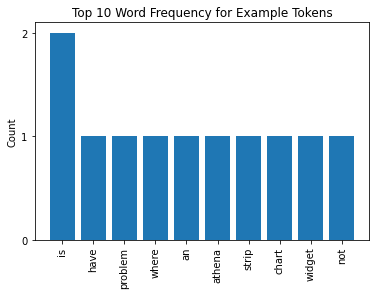

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(example_freq_dist, "Top 10 Word Frequency for Example Tokens")

pandas has a handy method called .explode() (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.explode.html#pandas.Series.explode) 

In [26]:
train_sample["text_tokenized"].explode()

1300             ncd
1300             has
1300              an
1300       excellent
1300        document
            ...     
1043    infringement
1043              on
1043           thier
1043            name
1043            sake
Name: text_tokenized, Length: 289, dtype: object

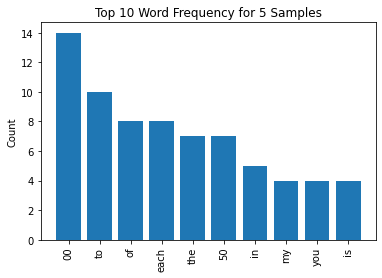

In [27]:
sample_freq_dist = FreqDist(train_sample["text_tokenized"].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency for 5 Samples")

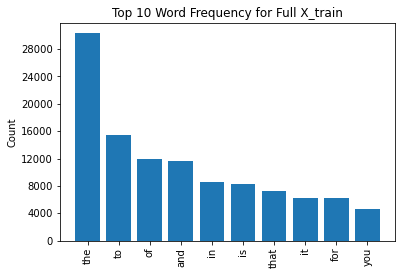

In [28]:
# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["text_tokenized"].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Full X_train")

Ok great, we have a general sense of the word frequencies in our dataset!

We can also subdivide this by category, to see if it makes a difference:

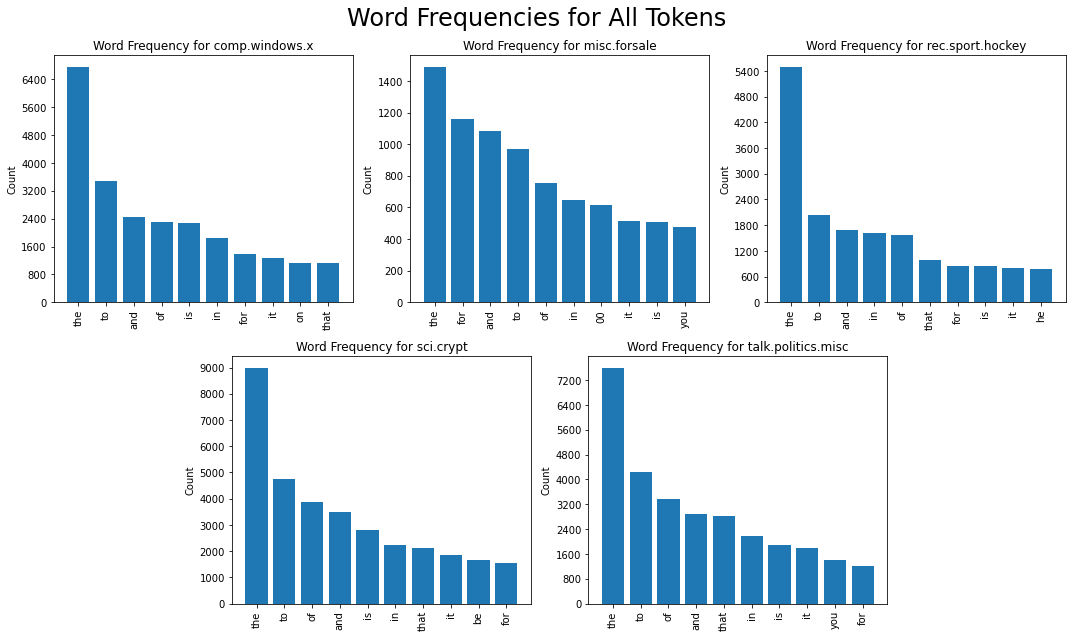

In [29]:

# Add in labels for filtering (we won't pass them in to the model)
X_train["label"] = [y_train[val] for val in X_train.index]

def setup_five_subplots():
    """
    It's hard to make an odd number of graphs pretty with just nrows
    and ncols, so we make a custom grid. See example for more details:
    https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html

    We want the graphs to look like this:
     [ ] [ ] [ ]
       [ ] [ ]

    So we make a 2x6 grid with 5 graphs arranged on it. 3 in the
    top row, 2 in the second row

      0 1 2 3 4 5
    0|[|]|[|]|[|]|
    1| |[|]|[|]| |
    """
    fig = plt.figure(figsize=(15,9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(2, 6)
    ax1 = fig.add_subplot(gs[0, :2]) # row 0, cols 0-1
    ax2 = fig.add_subplot(gs[0, 2:4])# row 0, cols 2-3
    ax3 = fig.add_subplot(gs[0, 4:]) # row 0, cols 4-5
    ax4 = fig.add_subplot(gs[1, 1:3])# row 1, cols 1-2
    ax5 = fig.add_subplot(gs[1, 3:5])# row 1, cols 3-4
    return fig, [ax1, ax2, ax3, ax4, ax5]

def plot_distribution_of_column_by_category(column, axes, title="Word Frequency for"):
    for index, category in enumerate(newsgroups_train.target_names):
        # Calculate frequency distribution for this subset
        all_words = X_train[X_train["label"] == index][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax = axes[index]
        ax.bar(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)


fig, axes = setup_five_subplots()
plot_distribution_of_column_by_category("text_tokenized", axes)
fig.suptitle("Word Frequencies for All Tokens", fontsize=24);

### TfidfVectorizer and MultinomialNB

In [30]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,and,for,in,is,it,of,that,the,to,you
0,0.322609,0.077590,0.304553,0.238740,0.203477,0.331334,0.290966,0.278467,0.334292,0.561259
1,0.090518,0.097966,0.096133,0.100479,0.000000,0.092966,0.104965,0.937591,0.253249,0.000000
2,0.173200,0.187451,0.367889,0.192259,0.196634,0.355768,0.401688,0.448504,0.484575,0.000000
3,0.468758,0.000000,0.355598,0.520342,0.152052,0.206330,0.077654,0.462422,0.312257,0.000000
4,0.000000,0.328237,0.322097,0.000000,0.000000,0.000000,0.000000,0.261785,0.848518,0.000000
...,...,...,...,...,...,...,...,...,...,...
2833,0.135376,0.097676,0.095849,0.450819,0.256154,0.370765,0.418620,0.350558,0.505001,0.058880
2834,0.296277,0.192393,0.755176,0.328880,0.000000,0.121716,0.274852,0.306886,0.110522,0.000000
2835,0.489400,0.794502,0.000000,0.000000,0.277808,0.000000,0.000000,0.000000,0.228205,0.000000
2836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Check the shape of your vectorized data:

In [31]:
# We should still have the same number of rows
assert X_train_vectorized.shape[0] == X_train.shape[0]

# The vectorized version should have 10 columns, since we set
# max_features=10
assert X_train_vectorized.shape[1] == 10

In [32]:
# Import relevant class and function
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.39964789, 0.41725352, 0.3943662 , 0.42151675, 0.37389771])

In [33]:
y_train.value_counts(normalize=True)

2    0.211416
3    0.209655
0    0.208950
1    0.206131
4    0.163848
Name: category, dtype: float64

### Iteratively Perform and Evaluate Preprocessing and Feature Engineering Techniques

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mellissavalle/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')
stopwords_list[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [39]:
print("Original list length:", len(stopwords_list))
stopwords_list.pop(stopwords_list.index("for"))
print("List length after removing 'for':", len(stopwords_list))

Original list length: 179
List length after removing 'for': 178


Function remove_stopwords that takes in a list-like collection of strings (tokens) and returns only those that are not in the list of stopwords. 

In [40]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [41]:
X_train["text_without_stopwords"] = X_train["text_tokenized"].apply(remove_stopwords)

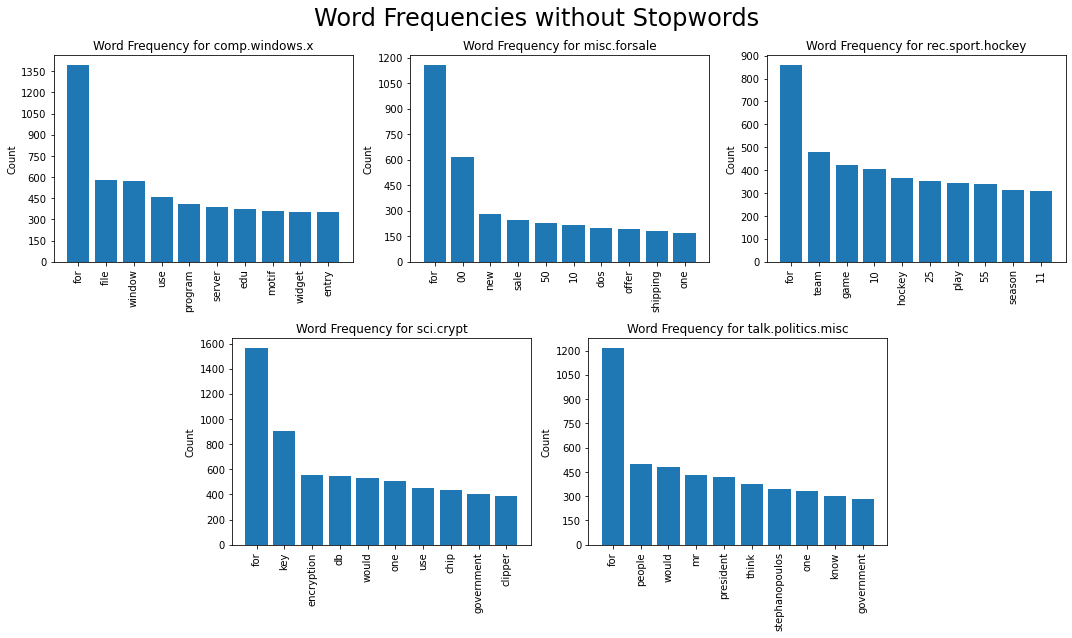

In [42]:
fig, axes = setup_five_subplots()
plot_distribution_of_column_by_category("text_without_stopwords", axes)
fig.suptitle("Word Frequencies without Stopwords", fontsize=24);

Redo our modeling process, using stopwords_list when instantiating the vectorizer:

In [43]:

# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,edu,for,get,key,like,new,one,people,use,would
0,0.000000,0.599601,0.000000,0.0,0.000000,0.561043,0.000000,0.570709,0.000000,0.000000
1,0.000000,0.502172,0.864768,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.525951,0.000000,0.850515
4,0.908329,0.418257,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2833,0.000000,0.575451,0.495478,0.0,0.476688,0.000000,0.000000,0.000000,0.000000,0.442862
2834,0.000000,0.867274,0.497831,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2835,0.000000,0.695901,0.000000,0.0,0.000000,0.000000,0.718138,0.000000,0.000000,0.000000
2836,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [44]:
# Evaluate the classifier on X_train_vectorized and y_train
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stopwords_removed_cv

array([0.40669014, 0.42077465, 0.37676056, 0.45502646, 0.42857143])

In [45]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.4013364135429863
Stopwords removed: 0.41756464714211183


### Using Custom Tokens

In [46]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [47]:
print("Original sample:", X_train.iloc[100]["text_tokenized"][20:30])
print("Stemmed sample: ", stem_and_tokenize(X_train.iloc[100]["text"])[20:30])

Original sample: ['happening', 'because', 'am', 'not', 'using', 'xtappmainloop', 'but', 'am', 'dealing', 'with']
Stemmed sample:  ['happen', 'becaus', 'am', 'not', 'use', 'xtappmainloop', 'but', 'am', 'deal', 'with']


We also need to stem our stopwords:

In [48]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [49]:

# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,file,for,get,key,like,new,one,peopl,use,would
0,0.0,0.501934,0.000000,0.000000,0.400150,0.469658,0.000000,0.476249,0.374901,0.000000
1,0.0,0.524938,0.851140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.556285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830992,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524754,0.000000,0.851254
4,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2833,0.0,0.588738,0.477293,0.000000,0.469351,0.000000,0.000000,0.000000,0.000000,0.453088
2834,0.0,0.879732,0.475469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2835,0.0,0.700743,0.000000,0.000000,0.000000,0.000000,0.713414,0.000000,0.000000,0.000000
2836,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
# Evaluate the classifier on X_train_vectorized and y_train
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stemmed_cv

array([0.45246479, 0.44542254, 0.41373239, 0.50440917, 0.46737213])

In [51]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.41756464714211183
Stemmed:           0.4566802046848995


### Domain-Specific Feature Engineering

###### Number of Sentences

In [53]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mellissavalle/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [54]:
from nltk.tokenize import sent_tokenize

sent_tokenize(X_train.iloc[100]["text"])

["i have a problem where an athena strip chart widget is not calling it's\nget value function.",
 'i am pretty sure this is happening because i am\nnot using xtappmainloop, but am dealing with events via sockets.',
 '(ya ya).',
 'anyway, i want to cause a timeout so that the strip chart widget(s) will\ncall their get value callback.',
 'or if someone knows another fast way around\nthis (or any way for that matter) let me know.',
 "i cannot (or i don't think)\ncall the xtngetvalue callback myself because i don't have the value for\nthe third parameter of the get value proc (xtpointer call_data).",
 'in other words, i want to force a strip chart widget to update itself.',
 'any ideas anyone?']

In [55]:
len(sent_tokenize(X_train.iloc[100]["text"]))

8

In [56]:
X_train["num_sentences"] = X_train["text"].apply(lambda x: len(sent_tokenize(x)))

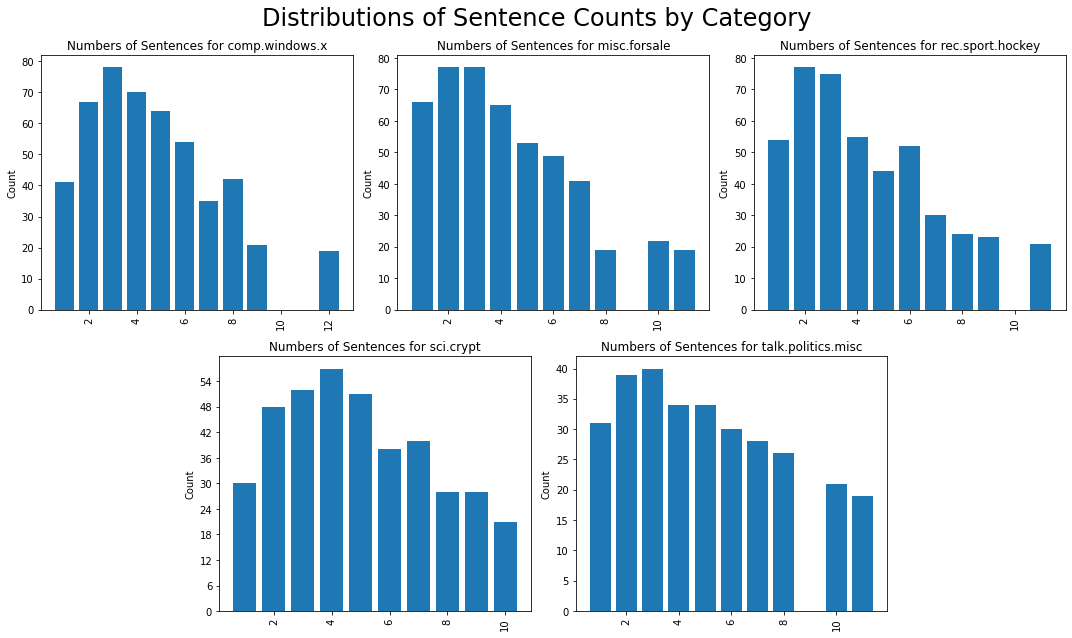

In [57]:
fig, axes = setup_five_subplots()
plot_distribution_of_column_by_category("num_sentences", axes, "Numbers of Sentences for")
fig.suptitle("Distributions of Sentence Counts by Category", fontsize=24);